In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
%%capture
import pandas as pd
import tensorflow as tf
import numpy as np
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

# Classification Model
!pip install transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Model Training
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# USE GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [ ]:
# USE TPU

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  0
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
# Get preprocessed data
!rm -rf "/content/Fake-News-Detection-Text-Classification"
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'
# read prepocessed data
data_path = '/content/Fake-News-Detection-Text-Classification/preprocessed_data/stemmed_and_stopword_removed_combined_set.csv'
combined_set = pd.read_csv(data_path)


Cloning into 'Fake-News-Detection-Text-Classification'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 42 (delta 11), reused 8 (delta 1), pack-reused 9
Receiving objects: 100% (42/42), 133.71 MiB | 11.78 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (9/9), done.


In [ ]:
CLASS_NAMES = ["Fake", "Real"]
MAPPING_DICT = {
    "Fake":0,
    "Real":1
}

combined_set.head()

,text,Label
0,us budget fight loom republican flip fiscal sc...,1.0
1,us militari accept transgend recruit monday pe...,1.0
2,senior us republican senat let mr mueller hi j...,1.0
3,fbi russia probe help australian diplomat tipo...,1.0
4,trump want postal servic charg much amazon shi...,1.0


In [ ]:
X = combined_set.sample(1000)
Y = X.Label.to_numpy().astype('float32').reshape(-1,1)
X = X.text.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    train_size=0.9,
    test_size=0.1,
    stratify=Y,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    train_size=0.9,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Model Callbacks
model_name = "BERTFakeNewsDetector"
MODEL_CALLBACKS = [ModelCheckpoint(model_name, save_best_only=True)]

In [ ]:
import tensorflow_addons as tfa
metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Approach 1

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    bert_name,
    padding = "max_length",
    do_lower_case = True,
    add_special_tokens = True,
)

X_train_encoded = tokenizer(
    X_train.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_valid_encoded = tokenizer(
    X_valid.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_test_encoded = tokenizer(
    X_test.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

train_ds = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).shuffle(len(X_train)).batch(8).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_encoded, y_valid)).shuffle(len(X_valid)).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

bert_model = TFAutoModelForSequenceClassification.from_pretrained(bert_name, num_labels = 1)

bert_model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall"),
        # tf.keras.metrics.F1Score(name='F1_Score'),
        # tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='F1_Score'),
        tf.keras.metrics.AUC(name='AUC')
    ]
)

model_history = bert_model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 3,
    batch_size = 16,
    callbacks = MODEL_CALLBACKS
)

model_history = pd.DataFrame(model_history.history)

# Save the mdoel
# bert_model.save(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/3
102/102 [==============================] - 196s 1s/step - loss: 0.1942 - Accuracy: 0.6790 - Precision: 0.6906 - Recall: 0.5623 - AUC: 0.7710 - val_loss: 0.1289 - val_Accuracy: 0.8222 - val_Precision: 0.7321 - val_Recall: 0.9762 - val_AUC: 0.9660
Epoch 2/3
102/102 [==============================] - 149s 1s/step - loss: 0.0810 - Accuracy: 0.9099 - Precision: 0.9108 - Recall: 0.8939 - AUC: 0.9620 - val_loss: 0.0351 - val_Accuracy: 0.9556 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9958
Epoch 3/3
102/102 [==============================] - 143s 1s/step - loss: 0.0422 - Accuracy: 0.9580 - Precision: 0.9598 - Recall: 0.9496 - AUC: 0.9892 - val_loss: 0.0219 - val_Accuracy: 0.9667 - val_Precision: 0.9756 - val_Recall: 0.9524 - val_AUC: 0.9980


In [ ]:
# Save the mdoel
bert_model.save(model_name)

In [ ]:
# Approach 2

from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
)

DATA_COLUMN = 'text'
LABEL_COLUMN = 'Lable'
MAX_SEQUENCE_LENGTH = 512
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
NUM_EPOCHS = 1
NUM_LABELS = 2 #len(X_train[LABEL_COLUMN].unique())  # = 2

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',
    padding = "max_length",
    do_lower_case = True,
    add_special_tokens = True)

def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    """Tokenize using the Huggingface tokenizer
    Args:
        sentences: String or list of string to tokenize
        padding: Padding method ['do_not_pad'|'longest'|'max_length']
    """
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )


# X_train_encoded = tokenize(X_train.tolist()).input_ids

# X_valid_encoded = tokenize(X_valid.tolist()).input_ids

# X_test_encoded = tokenize(X_test.tolist()).input_ids

# train_ds = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).shuffle(len(X_train)).batch(8).prefetch(tf.data.AUTOTUNE)
# valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_encoded, y_valid)).shuffle(len(X_valid)).batch(8).prefetch(tf.data.AUTOTUNE)
# test_ds  = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(X_train.tolist())),  # Convert BatchEncoding instance to dictionary
    y_train
)).shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(1)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(X_valid.tolist())),
    y_valid
)).batch(BATCH_SIZE).prefetch(1)

model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=NUM_LABELS
)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [
    tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
    tf.keras.metrics.Precision(name="Precision"),
    tf.keras.metrics.Recall(name="Recall"),
    tf.keras.metrics.F1Score(name='F1_Score'),
]
)
model_history = model.fit(
    x=train_dataset,
    y=None,
    validation_data=validation_dataset,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

model_history = pd.DataFrame(model_history.history)

# Save the mdoel
model.save(model_name)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=2, subplot_titles=("Loss", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"))

# Add traces to subplots
fig.add_trace(go.Scatter(y=model_history['loss'], mode='lines', name='Training Loss', showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(y=model_history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)

fig.add_trace(go.Scatter(y=model_history['Accuracy'], mode='lines', name='Training Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(y=model_history['val_Accuracy'], mode='lines', name='Validation Accuracy'), row=1, col=2)

fig.add_trace(go.Scatter(y=model_history['Precision'], mode='lines', name='Training Precision'), row=2, col=1)
fig.add_trace(go.Scatter(y=model_history['val_Precision'], mode='lines', name='Validation Precision'), row=2, col=1)

fig.add_trace(go.Scatter(y=model_history['Recall'], mode='lines', name='Training Recall'), row=2, col=2)
fig.add_trace(go.Scatter(y=model_history['val_Recall'], mode='lines', name='Validation Recall'), row=2, col=2)

# fig.add_trace(go.Scatter(y=model_history['F1_Score'], mode='lines', name='Training F1_Score'), row=3, col=1)
# fig.add_trace(go.Scatter(y=model_history['val_F1_Score'], mode='lines', name='Validation F1_Score'), row=3, col=1)

fig.add_trace(go.Scatter(y=model_history['AUC'], mode='lines', name='Training AUC'), row=3, col=2)
fig.add_trace(go.Scatter(y=model_history['val_AUC'], mode='lines', name='Validation AUC'), row=3, col=2)

# Customize the layout
fig.update_layout(
    title='Model Training History',
    xaxis_title='Epoch',
    yaxis_title='Metric Value',
    showlegend=False,
)

# Update subplot axes labels
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=2, col=1)
fig.update_xaxes(title_text='Epoch', row=2, col=2)

fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_yaxes(title_text='Precision', row=2, col=1)
fig.update_yaxes(title_text='Recall', row=2, col=2)
# fig.update_yaxes(title_text='F1_Score', row=3, col=1)
fig.update_yaxes(title_text='AUC', row=3, col=2)

# Display the figure
fig.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall, tests_f1, test_auc = bert_model.evaluate(test_ds, verbose = 0)

print(f"Test Loss      : {test_loss}")
print(f"Test Accuracy  : {test_acc}")
print(f"Test Precision : {test_precision}")
print(f"Test Recall    : {test_recall}")
print(f"Test F1        : {tests_f1}")
print(f"Test AUC       : {test_auc}")

Test Loss      : 0.05120176449418068
Test Accuracy  : 0.9200000166893005
Test Precision : 0.8571428656578064
Test Recall    : 1.0
Test F1        : [0.6486486]
Test AUC       : 0.9979968070983887


In [ ]:
def predict_text(text, model):
    tokens = tokenizer(text, return_tensors = 'tf', padding="max_length", truncation=True).input_ids
    return np.abs(np.round(model.predict(tokens, verbose = 0).logits))

In [ ]:
def generateWordCloud(text):
  wordcloud = WordCloud(
      width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

  fig = plt.figure(
    figsize = (3, 3),
    facecolor = 'k',
    edgecolor = 'k')

  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_true = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/FakeNewsData/True.csv")
data_fake = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/FakeNewsData/Fake.csv")

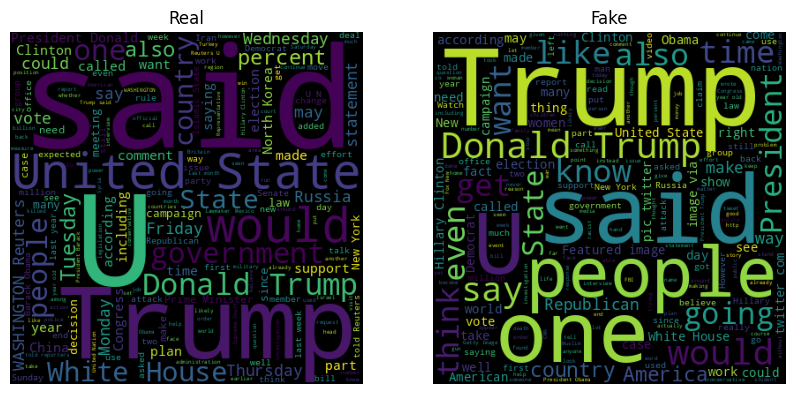

In [ ]:
# Generate the wordcloud objects

text_true = ''
for news in data_true.text.values:
    text_true += f" {news}"

text_fake = ''
for news in data_fake.text.values:
    text_fake += f" {news}"

real_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text_true)

fake_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text_fake)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the wordclouds on the subplots
ax1.imshow(real_wc)
ax1.set_title("Real")
ax1.axis("off")

ax2.imshow(fake_wc)
ax2.set_title("Fake")
ax2.axis("off")

# Show the figure
plt.show()

In [ ]:
def generateWordCloudComparative(text, real_wc=real_wc, fake_wc=fake_wc):

  # Create a figure with two subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

  text_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

  ax1.imshow(text_wc)
  ax1.set_title(text[:20] + "...")
  ax1.axis("off")

  ax2.imshow(real_wc)
  ax2.set_title("Real")
  ax2.axis("off")

  ax3.imshow(fake_wc)
  ax3.set_title("Fake")
  ax3.axis("off")

  # Show the figure
  plt.show()

ORGINAL TEXT:

muslim refuge dump garbag street protest insuffici wifi hous complaint lack wifi profession clean se

TRUE: Fake	PREDICTED: Real



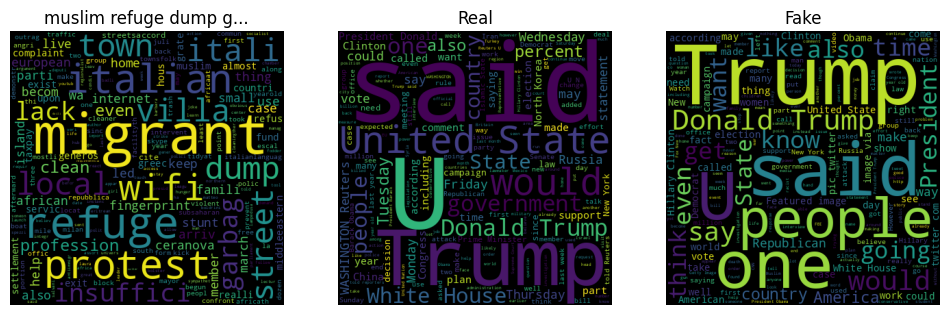

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

beauti christma present tax bracket could chang republican tax plan presid trump call tax plan beaut

TRUE: Fake	PREDICTED: Real



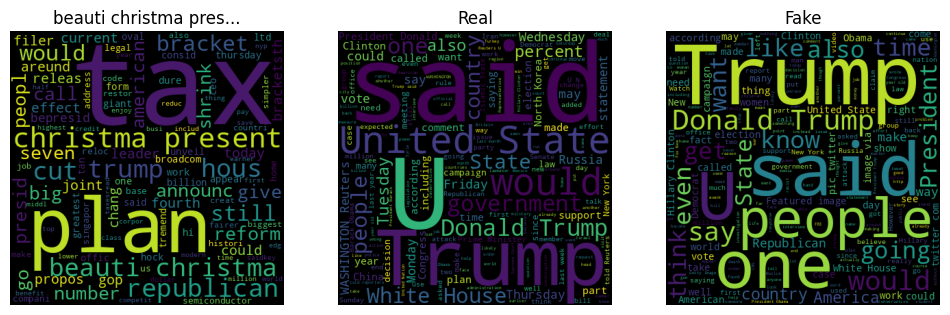

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

detroit suburb elect first muslim major citi council america video michigan republican governor rick

TRUE: Fake	PREDICTED: Real



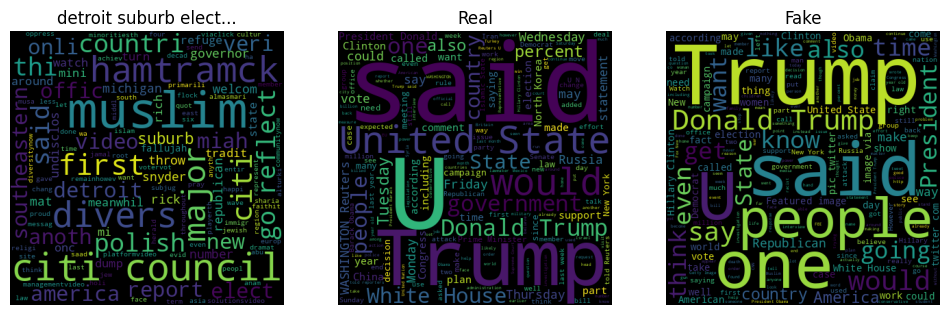

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

major outdoor cloth compani tie human traffick wage war presid trump outrag obama land grab ceo outd

TRUE: Fake	PREDICTED: Real



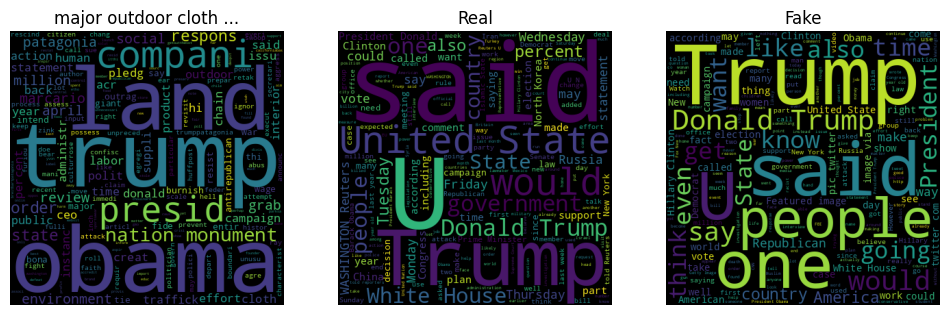

----------------------------------------------------------------------------------------------------



In [ ]:
# Print Misclassifications

count = 0
for index in range(len(X_test)):
    if count == 4: break

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true != model_pred):
      print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      # generateWordCloud(X_test[index])
      generateWordCloudComparative(X_test[index])
      print(f"{'-'*100}\n")
      count += 1


ORGINAL TEXT:

australia discuss north korea islamist terror manila talk australia prime minist malcolm turnbul sun

TRUE: Real	PREDICTED: Real



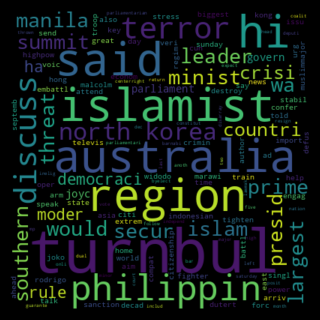

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

eu juncker say assum wont end deal brexit european commiss presid jeanclaud juncker said friday beli

TRUE: Real	PREDICTED: Real



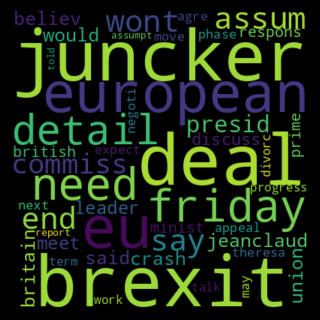

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

suprem court deni stay request north carolina redistrict case us suprem court friday refus stay rule

TRUE: Real	PREDICTED: Real



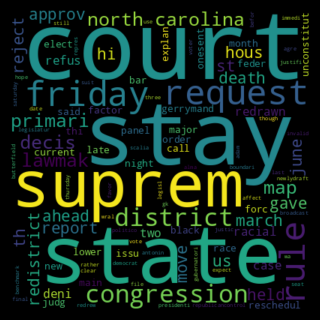

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

nevertrump weekli standard editor send vile tweet mock vp pencesuggest penc ha replac god presid tru

TRUE: Fake	PREDICTED: Fake



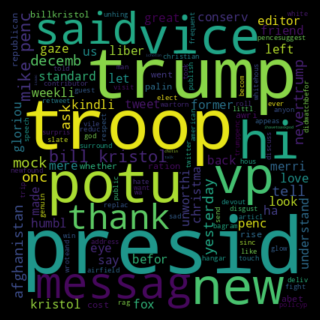

----------------------------------------------------------------------------------------------------



In [ ]:
# Print correct classifications

count = 0
for index in range(len(X_test)):
    if count == 4: break

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true == model_pred):
      print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      generateWordCloud(X_test[index])
      print(f"{'-'*100}\n")
      count += 1
